In [9]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict

# Definicje

In [10]:
env = gym.make("Blackjack-v1", natural = True, sab=False)

# Hiperparametry
alpha = 0.5          # Dużo niższy start! Nie chcemy, żeby jedno rozdanie zmieniało całą wiedzę.
alpha_min = 0.01     # W Blackjacku warto zostawić mały poziom uczenia na stałe.
alpha_decay = 0.99999 # Wolniejszy spadek, żeby zdążył przejść przez 200k epizodów.

gamma = 0.95

epsilon = 1.0        # STARTUJEMY OD 1. Agent na początku musi grać losowo.
epsilon_min = 0.05
epsilon_decay = 0.99998 # Epsilon musi maleć, żeby agent zaczął stosować to, co umie.

num_episodes = 200_000

In [11]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q[state][action]

# Pomocnicze funkcje

In [12]:
def basic_strategy(state):
    player_sum, dealer_card, usable_ace = state
    if player_sum >= 17:
        return 0  # stick
    else:
        return 1  # hit

def choose_action(state):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])
    
def q_policy(state):
    return np.argmax(Q[state])


In [13]:
def evaluate_policy(policy_fn, n_games=100_000):
    wins = 0
    losses = 0
    draws = 0

    for _ in range(n_games):
        state, _ = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    return wins, losses, draws

# Trenowanie agenta

In [14]:
rewards_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0.0

    while not done:
        action = choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        if terminated:
            # Jeśli to koniec, cel to po prostu nagroda
            target = reward
        else:
            # Jeśli gra trwa, cel to nagroda + szacowana przyszłość
            target = reward + gamma * np.max(Q[next_state])

        # Aktualizacja o różnicę między celem a obecną wiedzą
        Q[state][action] += alpha * (target - Q[state][action])

        state = next_state
        done = terminated or truncated

    # Wygaszanie parametrów po każdym epizodzie
    alpha = max(alpha_min, alpha * alpha_decay)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_history.append(ep_reward)


# Porównanie z klasyczną

In [15]:
wins_q, losses_q, draws_q = evaluate_policy(q_policy)
wins_bs, losses_bs, draws_bs = evaluate_policy(basic_strategy)

print("Q-learning: Wins:", wins_q, "Losses:", losses_q, "Draws:", draws_q)
print("Basic Strategy: Wins:", wins_bs, "Losses:", losses_bs, "Draws:", draws_bs)

Q-learning: Wins: 42314 Losses: 48134 Draws: 9552
Basic Strategy: Wins: 40770 Losses: 48762 Draws: 10468


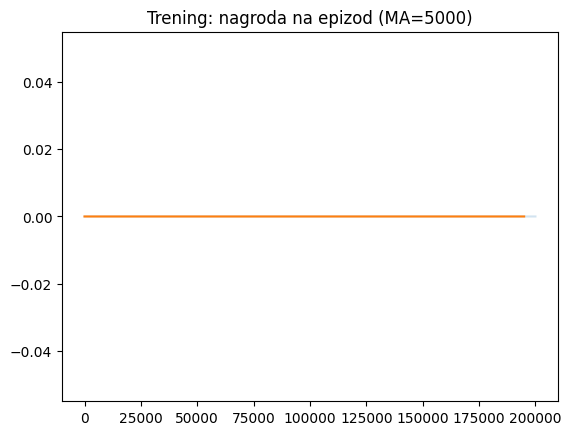

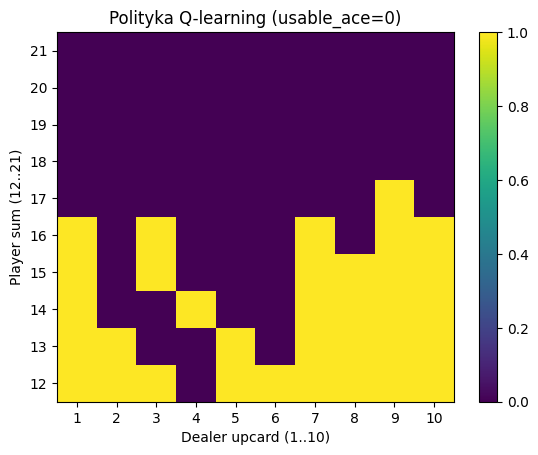

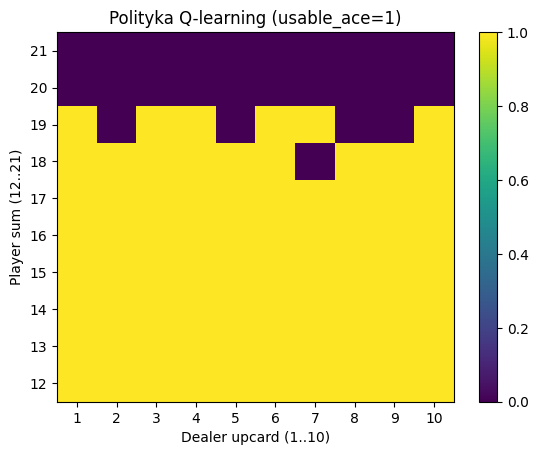

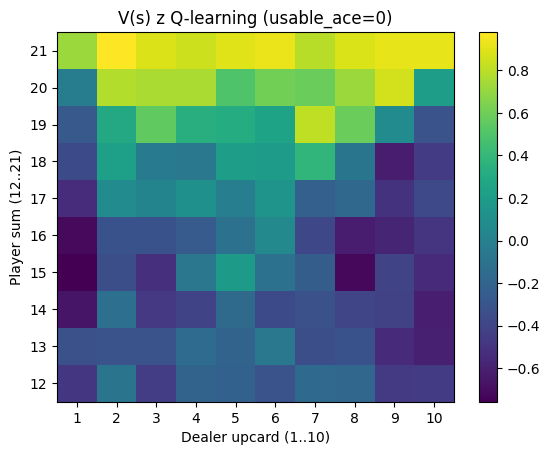

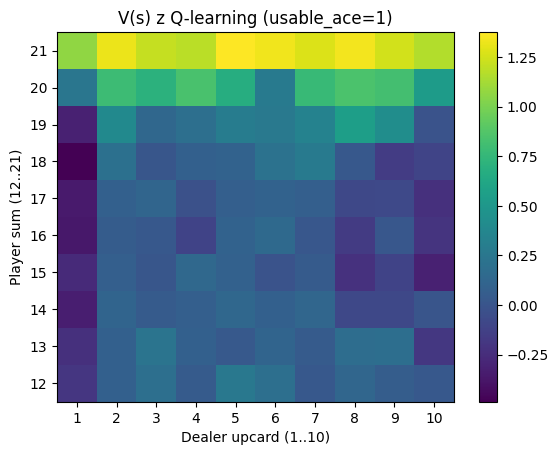

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(x, w):
    x = np.asarray(x, dtype=np.float32)
    if len(x) < w:
        return x
    return np.convolve(x, np.ones(w, dtype=np.float32)/w, mode='valid')

rewards = np.asarray(rewards_history, dtype=np.float32)
plt.figure()
plt.plot(rewards, alpha=0.2)
plt.plot(moving_avg(rewards, 5000))
plt.title('Trening: nagroda na epizod (MA=5000)')
plt.show()

def plot_policy_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)))
    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            state = (s, d, usable_ace)
            grid[i, j] = int(np.argmax(Q[state]))
    plt.figure()
    plt.imshow(grid, origin='lower', aspect='auto')
    plt.title(f'Polityka Q-learning (usable_ace={usable_ace})')
    plt.xlabel('Dealer upcard (1..10)')
    plt.ylabel('Player sum (12..21)')
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar()
    plt.show()

def plot_value_heatmap(usable_ace):
    sums = range(12, 22)
    dealers = range(1, 11)
    grid = np.zeros((len(sums), len(dealers)), dtype=np.float32)
    for i, s in enumerate(sums):
        for j, d in enumerate(dealers):
            state = (s, d, usable_ace)
            grid[i, j] = float(np.max(Q[state]))
    plt.figure()
    plt.imshow(grid, origin='lower', aspect='auto')
    plt.title(f'V(s) z Q-learning (usable_ace={usable_ace})')
    plt.xlabel('Dealer upcard (1..10)')
    plt.ylabel('Player sum (12..21)')
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.yticks(np.arange(10), np.arange(12, 22))
    plt.colorbar()
    plt.show()

plot_policy_heatmap(0)
plot_policy_heatmap(1)
plot_value_heatmap(0)
plot_value_heatmap(1)
